In [204]:
from PIL import Image
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

In [205]:
from tensorflow.keras import layers 
from tensorflow.keras import models
from tensorflow.keras import optimizers
from tensorflow.keras import Input
from tensorflow.keras import preprocessing
from tensorflow.keras import backend
from tensorflow.keras import utils
from tensorflow.keras import callbacks
from tensorflow.keras import losses

## Functions

In [207]:
def plot_sample_images(X_train, X_ann, count_images=3):
    fig = plt.figure(figsize=(15, 10)) #создаем фигуру
    k = 0
    img_ids = len(X_train)
    for _ in range(count_images):
        idx = np.random.randint(0,img_ids) 
        img = X_train[idx][0] 
        fig.add_subplot(3, 3, k + 1) 
        plt.imshow(img) 
        plt.title('Image')
        plt.axis('off') 

        mask = X_ann[idx][0] 
        fig.add_subplot(3, 3, k + 2) 
        plt.imshow(mask) 
        plt.title('Annnotation') 
        plt.axis('off') 
        
        mask = X_ann[idx][0]
        mask = mask | img #преобразуем маску
        fig.add_subplot(3, 3, k + 3) # добавляем холст для вывода изображений
        plt.imshow(mask)
        plt.title('Mask') #даем название холсту
        k += 3
    plt.show() 
    
def plot_sample_predictions(model, generator, count_images=3, filter_classes = ['person']):
    images, masks = generator.__getitem__(np.random.randint(0, len(generator)))
#     images = cv2.cvtColor(images, cv2.COLOR_BGR2RGB)
    fig = plt.figure(figsize=(15, 10)) #создаем фигуру
    k = 0
    for i in range(count_images):
        idx = np.random.randint(0, len(images)) #берем случайное имя файла
        fig.add_subplot(3, 3, k + 1) # добавляем холст для вывода изображений
#         images[idx] = cv2.cvtColor(images[idx], cv2.COLOR_BGR2RGB)
        plt.imshow(images[idx]) #вывод изображения на экран
        plt.title('Image') #даем название холсту
        plt.axis('off') #отключаем оси
        
        fig.add_subplot(3, 3, k + 2) # добавляем холст для вывода изображений
#         masks[idx] = cv2.cvtColor(masks[idx], cv2.COLOR_BGR2RGB)
        plt.imshow(masks[idx]) #вывод изображения на экран
        plt.title('Mask') #даем название холсту
        plt.axis('off') #отключаем оси
        
        image = images[idx]
        image = images[idx].reshape(1, image.shape[0], image.shape[1], image.shape[2])
        predicted_mask = model.predict(image)
        fig.add_subplot(3, 3, k + 3) # добавляем холст для вывода изображений
#         images[idx] = cv2.cvtColor(images[idx], cv2.COLOR_BGR2RGB)
        plt.imshow(predicted_mask[0, :, :, :])
        plt.title('Predicted mask') #даем название холсту
        k += 3
    plt.show() 

## Data exploration

In [208]:
# TRAIN_IMAGE_PATH = '../input/coco2017/train2017/train2017'
# VAL_IMAGE_PATH = '../input/coco2017/val2017/val2017'
# TRAIN_MASK_PATH = 'masks/train2017'
# VAL_MASK_PATH = 'masks/val2017'
# TRAIN_ANOT_PATH = '../input/coco-data/annotations/instances_train2017.json'
# VAL_ANOT_PATH = '../input/coco-data/annotations/instances_val2017.json'
CHECKPOINT_PATH = '/models/'
# CATEGORY_NAMES = ['person']
SEED = 2021
IMAGE_SIZE = (128, 128)
INPUT_SHAPE = (128, 128, 3)
BATCH_SIZE = 32

In [209]:
np.random.seed = SEED

In [210]:
import shutil
from tqdm import tqdm

In [211]:
mkdir TRAIN VAL VAL/image VAL/ann TRAIN/image TRAIN/ann TEST TEST/T1 TEST/T2

mkdir: cannot create directory ‘TRAIN’: File exists
mkdir: cannot create directory ‘VAL’: File exists
mkdir: cannot create directory ‘VAL/image’: File exists
mkdir: cannot create directory ‘VAL/ann’: File exists
mkdir: cannot create directory ‘TRAIN/image’: File exists
mkdir: cannot create directory ‘TRAIN/ann’: File exists
mkdir: cannot create directory ‘TEST’: File exists
mkdir: cannot create directory ‘TEST/T1’: File exists
mkdir: cannot create directory ‘TEST/T2’: File exists


In [213]:
IMG_PATH = '../input/wcebleedgen/WCEBleedGen/WCEBleedGen/bleeding/Images'
ANN_PATH = '../input/wcebleedgen/WCEBleedGen/WCEBleedGen/bleeding/Annotations'
# split the data by train/val/test
IMG_NUM = len(os.listdir(IMG_PATH))
for (n, FILE_NAME) in enumerate(os.listdir(IMG_PATH)):
    (_, no) = FILE_NAME.split('-')
    img = IMG_PATH + '/' + FILE_NAME
    ann = ANN_PATH + '/ann-' + no
    n1=no[1:]
    if n < 0.8*IMG_NUM:
        shutil.copy(img, 'TRAIN/' + '/image/' + n1)
        shutil.copy(ann, 'TRAIN/' + '/ann/' + n1)
    else:
        shutil.copy(img, 'VAL/' + '/image/' + n1)
        shutil.copy(ann, 'VAL/' + '/ann/' + n1)


In [214]:
IMG_PATH = '../input/wcebleedgen/Test Dataset/Test Dataset 2'
IMG_NUM = len(os.listdir(IMG_PATH))
for (n, FILE_NAME) in enumerate(os.listdir(IMG_PATH)):
    img = IMG_PATH + '/' + FILE_NAME
    shutil.copy(img, 'TEST'+ '/T1/' + FILE_NAME)

## Data generator

In [217]:
class DataGen(utils.Sequence):
    
    def __init__(self, path_input, path_mask, batch_size = 8, image_size = (128, 128)):
        
        self.ids = os.listdir(path_mask)
        self.path_input = path_input
        self.path_mask = path_mask
        self.batch_size = batch_size
        self.image_size = image_size
    
    def __load__(self , id_name):
        image_path = os.path.join(self.path_input , id_name)
        mask_path = os.path.join(self.path_mask , id_name) 

        image = cv2.imread(image_path , 1) # 1 specifies RGB format
        image = cv2.resize(image , self.image_size) # resizing before inserting to the network

        mask = cv2.imread(mask_path , -1)
        mask = cv2.resize(mask , self.image_size)
        if mask.shape[-1] == 3:
            mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
        mask = mask.reshape((self.image_size[0] , self.image_size[1] , 1))

        #normalize image
        image = image / 255.0
        mask = mask / 255.0

        return image , mask
    
    def __getitem__(self , index):
    
        if (index + 1)*self.batch_size > len(self.ids):
            self.batch_size = len(self.ids) - index * self.batch_size

        file_batch = self.ids[index * self.batch_size : (index + 1) * self.batch_size]
        images = []
        masks = []

        for id_name in file_batch : 
            _img , _mask = self.__load__(id_name)
            images.append(_img)
            masks.append(_mask)
        images = np.array(images)
        masks = np.array(masks)


        return images , masks
  
    def __len__(self):
        return int(np.ceil(len(self.ids) / float(self.batch_size)))

In [218]:
TRAIN_IMAGE_PATH = "TRAIN/image"
TRAIN_MASK_PATH = "TRAIN/ann"

VAL_IMAGE_PATH = "VAL/image"
VAL_MASK_PATH = "VAL/ann"


In [219]:
train_gen = DataGen(
    path_input = TRAIN_IMAGE_PATH, 
    path_mask = TRAIN_MASK_PATH, 
    batch_size = BATCH_SIZE, 
    image_size = IMAGE_SIZE
)
val_gen = DataGen(
    path_input =  VAL_IMAGE_PATH, 
    path_mask =  VAL_MASK_PATH, 
    batch_size = BATCH_SIZE, 
    image_size = IMAGE_SIZE
)

In [220]:
train_gen[1][1].shape

(32, 128, 128, 1)

## Model

In [221]:
def down_block(input_tensor, no_filters, kernel_size=(3, 3),
    strides=(1, 1),
    padding="same",
    kernel_initializer="he_normal",
    max_pool_window=(2, 2),
    max_pool_stride=(2, 2)
):
    conv = layers.Conv2D(
        filters=no_filters,
        kernel_size=kernel_size,
        strides=strides,
        activation=None,
        padding=padding,
        kernel_initializer=kernel_initializer
    )(input_tensor)
    conv = layers.BatchNormalization(scale=True)(conv)
    conv = layers.Activation("relu")(conv)
    conv = layers.Conv2D(
        filters=no_filters,
        kernel_size=kernel_size,
        strides=strides,
        activation=None,
        padding=padding,
        kernel_initializer=kernel_initializer
    )(conv)
    conv = layers.BatchNormalization(scale=True)(conv)
    conv = layers.Activation("relu")(conv)
    pool = layers.MaxPooling2D(pool_size=max_pool_window, strides=max_pool_stride)(conv)
    return conv, pool

def bottle_neck(
    input_tensor,
    no_filters,
    kernel_size=(3, 3),
    strides=(1, 1),
    padding="same",
    kernel_initializer="he_normal"
):
    conv = layers.Conv2D(
        filters=no_filters,
        kernel_size=kernel_size,
        strides=strides,
        activation=None,
        padding=padding,
        kernel_initializer=kernel_initializer
    )(input_tensor)
    conv = layers.BatchNormalization(scale=True)(conv)
    conv = layers.Activation("relu")(conv)
    conv = layers.Conv2D(
        filters=no_filters,
        kernel_size=kernel_size,
        strides=strides,
        activation=None,
        padding=padding,
        kernel_initializer=kernel_initializer
    )(conv)
    conv = layers.BatchNormalization(scale=True)(conv)
    conv = layers.Activation("relu")(conv)
    return conv

def up_block(    
    input_tensor,
    no_filters,
    skip_connection, 
    kernel_size=(3, 3),
    strides=(1, 1),
    upsampling_factor = (2,2),
    max_pool_window = (2,2),
    padding="same",
    kernel_initializer="he_normal"):
    
    
    conv = layers.Conv2D(
        filters = no_filters,
        kernel_size= max_pool_window,
        strides = strides,
        activation = None,
        padding = padding,
        kernel_initializer=kernel_initializer
    )(layers.UpSampling2D(size = upsampling_factor)(input_tensor))
    conv = layers.BatchNormalization(scale=True)(conv)
    conv = layers.Activation("relu")(conv) 
    conv = layers.concatenate( [skip_connection , conv]  , axis = -1)
    conv = layers.Conv2D(
        filters=no_filters,
        kernel_size=kernel_size,
        strides=strides,
        activation=None,
        padding=padding,
        kernel_initializer=kernel_initializer
    )(conv)
    conv = layers.BatchNormalization(scale=True)(conv)
    conv = layers.Activation("relu")(conv)
    conv = layers.Conv2D(
        filters=no_filters,
        kernel_size=kernel_size,
        strides=strides,
        activation=None,
        padding=padding,
        kernel_initializer=kernel_initializer
    )(conv)
    conv = layers.BatchNormalization(scale=True)(conv)
    conv = layers.Activation("relu")(conv)
    return conv

def output_block(input_tensor,
    padding="same",
    kernel_initializer="he_normal"
):
    
    conv = layers.Conv2D(
        filters=2,
        kernel_size=(3,3),
        strides=(1,1),
        activation="relu",
        padding=padding,
        kernel_initializer=kernel_initializer
    )(input_tensor)
    conv = layers.Conv2D(
        filters=1,
        kernel_size=(1,1),
        strides=(1,1),
        activation="sigmoid",
        padding=padding,
        kernel_initializer=kernel_initializer
    )(conv)
    return conv

def UNet(input_shape = (128,128,3)):
    
    filter_size = [64,128,256,512,1024]
    inputs = Input(shape=input_shape)
    
    d1 , p1 = down_block(input_tensor= inputs,
                         no_filters=filter_size[0],
                         kernel_size = (3,3),
                         strides=(1,1),
                         padding="same",
                         kernel_initializer="he_normal",
                         max_pool_window=(2,2),
                         max_pool_stride=(2,2))
    d2 , p2 = down_block(input_tensor= p1,
                         no_filters=filter_size[1],
                         kernel_size = (3,3),
                         strides=(1,1),
                         padding="same",
                         kernel_initializer="he_normal",
                         max_pool_window=(2,2),
                         max_pool_stride=(2,2))
    d3 , p3 = down_block(input_tensor= p2,
                         no_filters=filter_size[2],
                         kernel_size = (3,3),
                         strides=(1,1),
                         padding="same",
                         kernel_initializer="he_normal",
                         max_pool_window=(2,2),
                         max_pool_stride=(2,2))
    d4 , p4 = down_block(input_tensor= p3,
                         no_filters=filter_size[3],
                         kernel_size = (3,3),
                         strides=(1,1),
                         padding="same",
                         kernel_initializer="he_normal",
                         max_pool_window=(2,2),
                         max_pool_stride=(2,2))    
    b = bottle_neck(input_tensor= p4,
                         no_filters=filter_size[4],
                         kernel_size = (3,3),
                         strides=(1,1),
                         padding="same",
                         kernel_initializer="he_normal")
    u4 = up_block(input_tensor = b,
                  no_filters = filter_size[3],
                  skip_connection = d4,
                  kernel_size=(3, 3),
                  strides=(1, 1),
                  upsampling_factor = (2,2),
                  max_pool_window = (2,2),
                  padding="same",
                  kernel_initializer="he_normal")
    u3 = up_block(input_tensor = u4,
                  no_filters = filter_size[2],
                  skip_connection = d3,
                  kernel_size=(3, 3),
                  strides=(1, 1),
                  upsampling_factor = (2,2),
                  max_pool_window = (2,2),
                  padding="same",
                  kernel_initializer="he_normal")
    u2 = up_block(input_tensor = u3,
                  no_filters = filter_size[1],
                  skip_connection = d2,
                  kernel_size=(3, 3),
                  strides=(1, 1),
                  upsampling_factor = (2,2),
                  max_pool_window = (2,2),
                  padding="same",
                  kernel_initializer="he_normal")
    u1 = up_block(input_tensor = u2,
                  no_filters = filter_size[0],
                  skip_connection = d1,
                  kernel_size=(3, 3),
                  strides=(1, 1),
                  upsampling_factor = (2,2),
                  max_pool_window = (2,2),
                  padding="same",
                  kernel_initializer="he_normal")
    output = output_block(input_tensor=u1 , 
                         padding = "same",
                         kernel_initializer= "he_normal")
    model = models.Model(inputs = inputs , outputs = output)
    return model

In [222]:
model = UNet(input_shape = INPUT_SHAPE)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_48 (Conv2D)             (None, 128, 128, 64  1792        ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_44 (BatchN  (None, 128, 128, 64  256        ['conv2d_48[0][0]']              
 ormalization)                  )                                                           

## Training

In [223]:
def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = backend.flatten(y_true)
    y_pred_f = backend.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2. * backend.sum(intersection) + smooth) / (backend.sum(y_true_f) + backend.sum(y_pred_f) + smooth)
    return 1. - score

def bce_dice_loss(y_true, y_pred):
    return losses.binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

def iou_coef(y_true, y_pred, smooth=1):
    intersection = backend.sum(backend.abs(y_true * y_pred), axis=[1,2,3])
    union = backend.sum(y_true,[1,2,3])+backend.sum(y_pred,[1,2,3])-intersection
    iou = backend.mean((intersection + smooth) / (union + smooth), axis=0)
    return iou

In [224]:
initial_learning_rate = 1e-4

model.compile(
    optimizer = optimizers.Adam(lr = initial_learning_rate),
    loss = bce_dice_loss,
    metrics = [iou_coef]
)


In [225]:
def lr_exp_decay(epoch, lr):
    k = 0.1
    return initial_learning_rate * np.exp(-k*epoch)
callbacks_list = [
    callbacks.ReduceLROnPlateau(
        monitor = 'val_loss', 
        patience = 2, 
        verbose = 1, 
        min_lr=1e-7), 
    callbacks.EarlyStopping(
        monitor = 'val_loss', 
        patience = 5,
        verbose = 1, 
        restore_best_weights = True), 
    callbacks.ModelCheckpoint(
        filepath=CHECKPOINT_PATH + 'unet_best_model.hdf5', 
        monitor='val_loss',
        verbose=1, 
        save_best_only=True),
    callbacks.LearningRateScheduler(
        lr_exp_decay, 
        verbose=1
    )
]

In [226]:
len(train_gen)

33


Epoch 1: LearningRateScheduler setting learning rate to 0.0001.
33/33 [==============================] - ETA: 0s - loss: 1.0689 - iou_coef: 0.1867
Epoch 1: val_loss improved from inf to 1.25285, saving model to /models/unet_best_model.hdf5
1/1 [==============================] - 0s 19ms/step


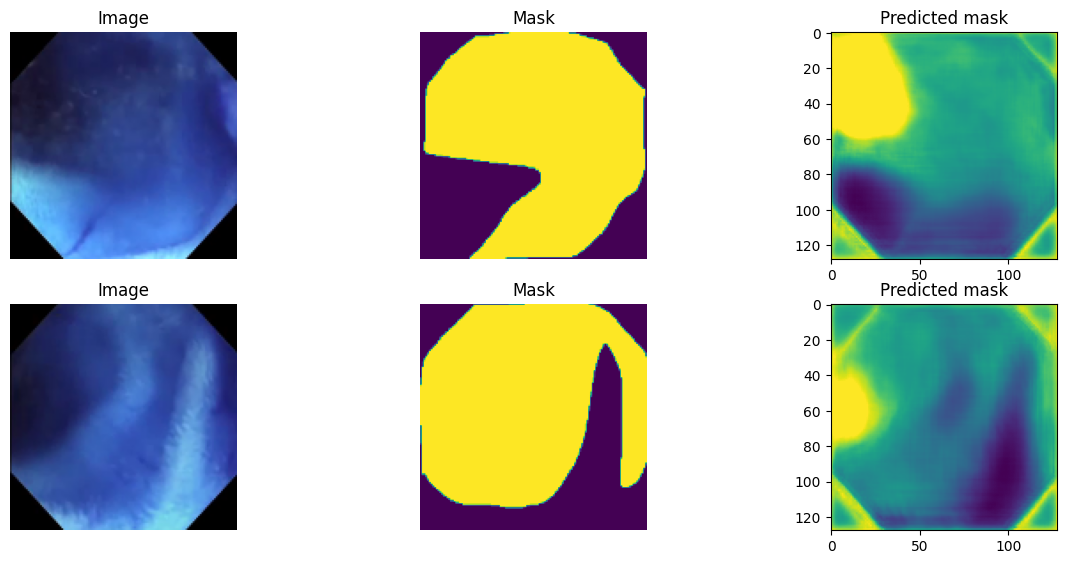


Epoch 1: LearningRateScheduler setting learning rate to 0.0001.
44/44 [==============================] - ETA: 0s - loss: 0.8607 - iou_coef: 0.2293
Epoch 1: val_loss improved from 1.25285 to 1.19073, saving model to /models/unet_best_model.hdf5
1/1 [==============================] - 0s 21ms/step


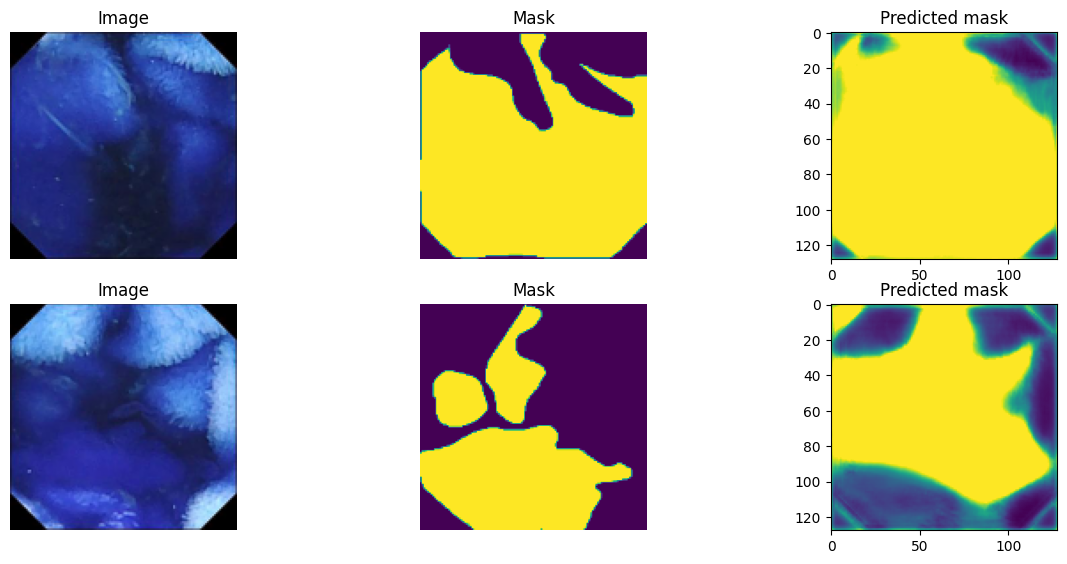


Epoch 1: LearningRateScheduler setting learning rate to 0.0001.
66/66 [==============================] - ETA: 0s - loss: 0.8059 - iou_coef: 0.2556
Epoch 1: val_loss improved from 1.19073 to 1.13487, saving model to /models/unet_best_model.hdf5
1/1 [==============================] - 0s 19ms/step


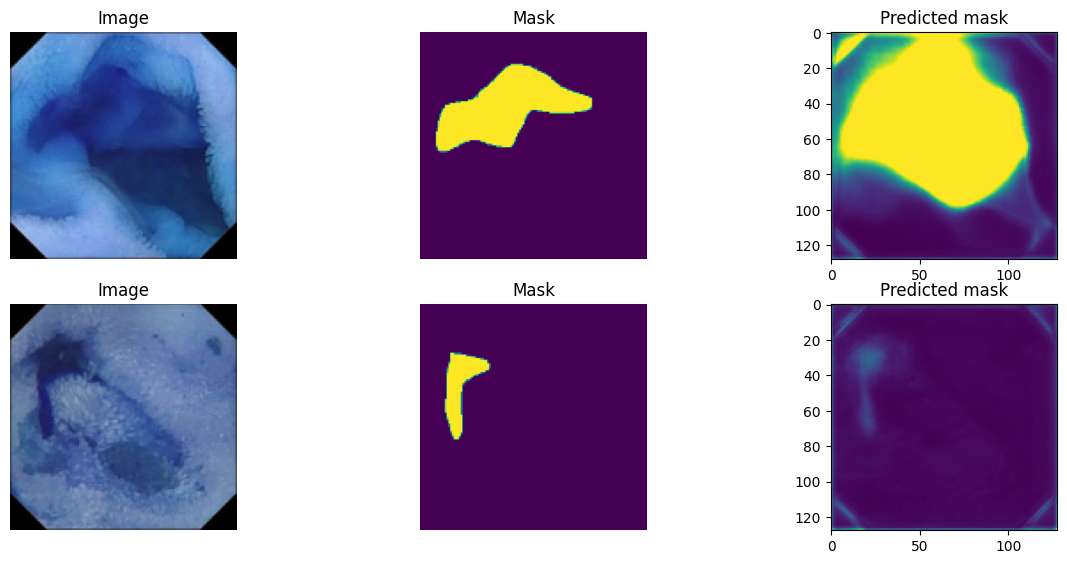


Epoch 1: LearningRateScheduler setting learning rate to 0.0001.
131/131 [==============================] - ETA: 0s - loss: 0.8344 - iou_coef: 0.2516
Epoch 1: val_loss improved from 1.13487 to 1.04170, saving model to /models/unet_best_model.hdf5
1/1 [==============================] - 0s 19ms/step


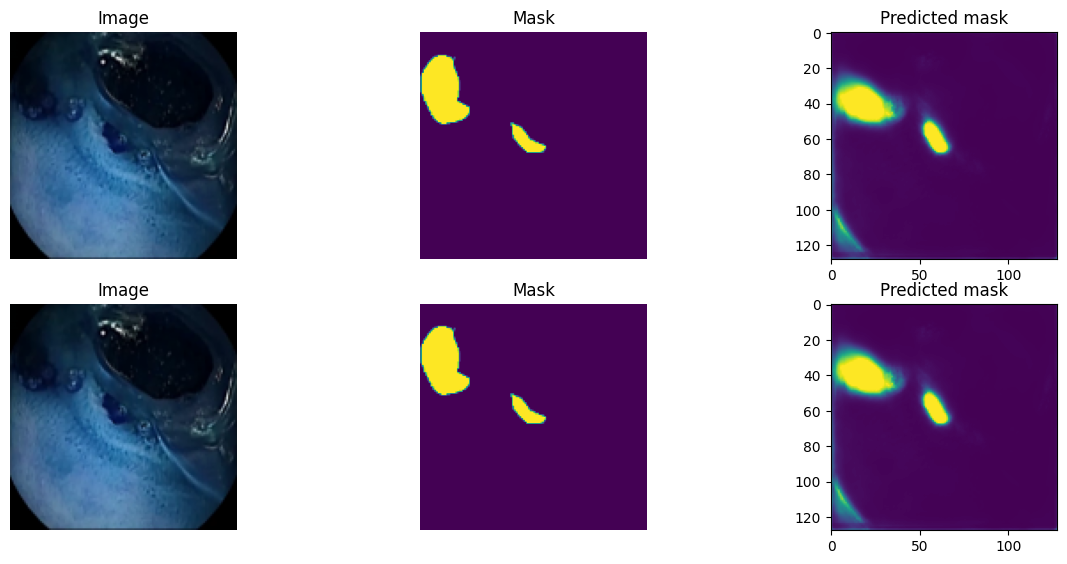


Epoch 1: LearningRateScheduler setting learning rate to 0.0001.
131/131 [==============================] - ETA: 0s - loss: 0.7944 - iou_coef: 0.2727
Epoch 1: val_loss improved from 1.04170 to 0.93265, saving model to /models/unet_best_model.hdf5
1/1 [==============================] - 0s 20ms/step


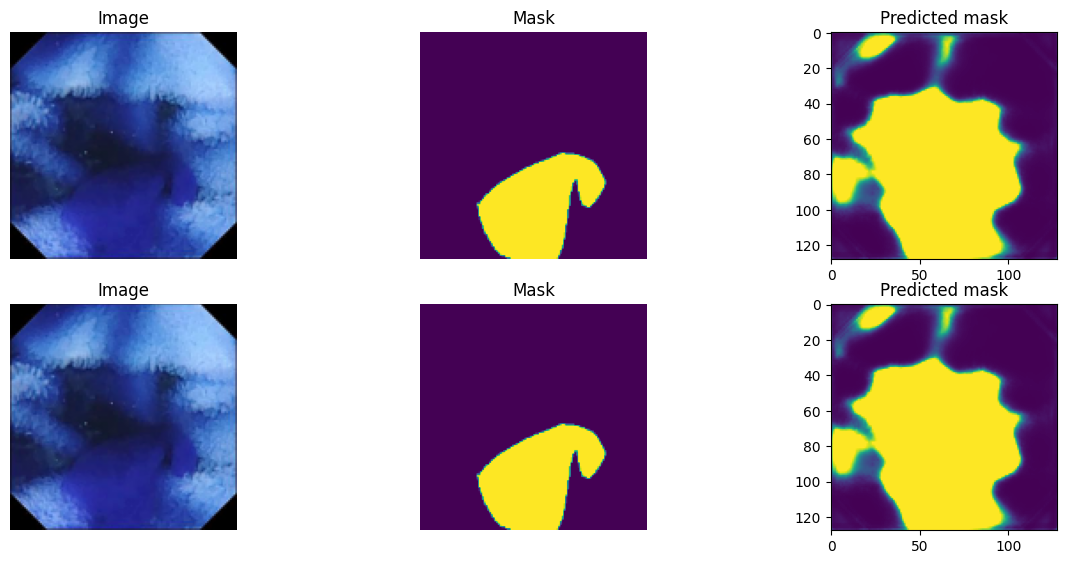


Epoch 1: LearningRateScheduler setting learning rate to 0.0001.
131/131 [==============================] - ETA: 0s - loss: 0.7626 - iou_coef: 0.2887
Epoch 1: val_loss improved from 0.93265 to 0.85625, saving model to /models/unet_best_model.hdf5
1/1 [==============================] - 0s 18ms/step


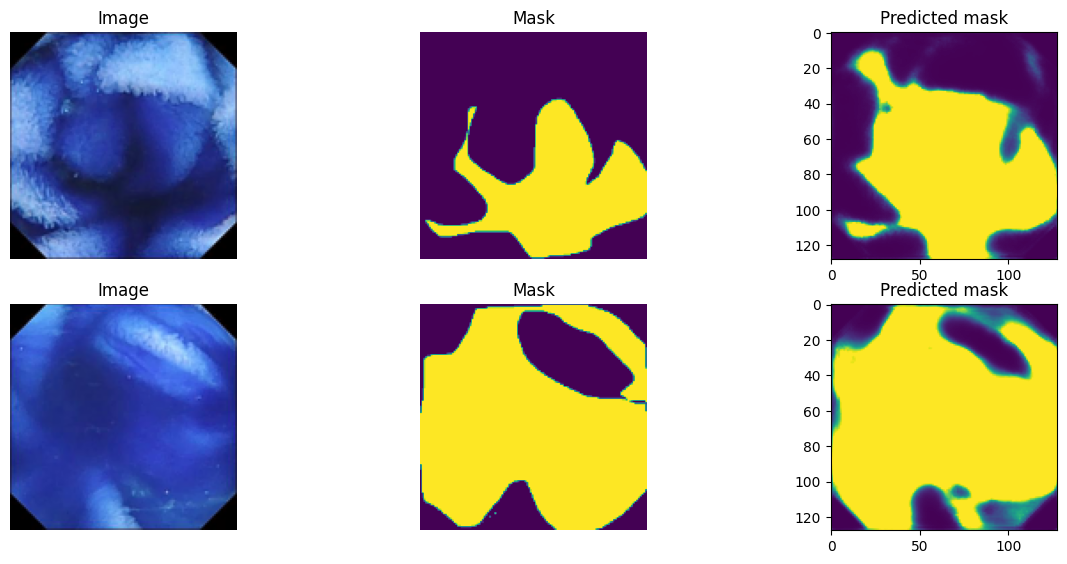


Epoch 1: LearningRateScheduler setting learning rate to 0.0001.
131/131 [==============================] - ETA: 0s - loss: 0.7427 - iou_coef: 0.2989
Epoch 1: val_loss improved from 0.85625 to 0.81190, saving model to /models/unet_best_model.hdf5
1/1 [==============================] - 0s 20ms/step


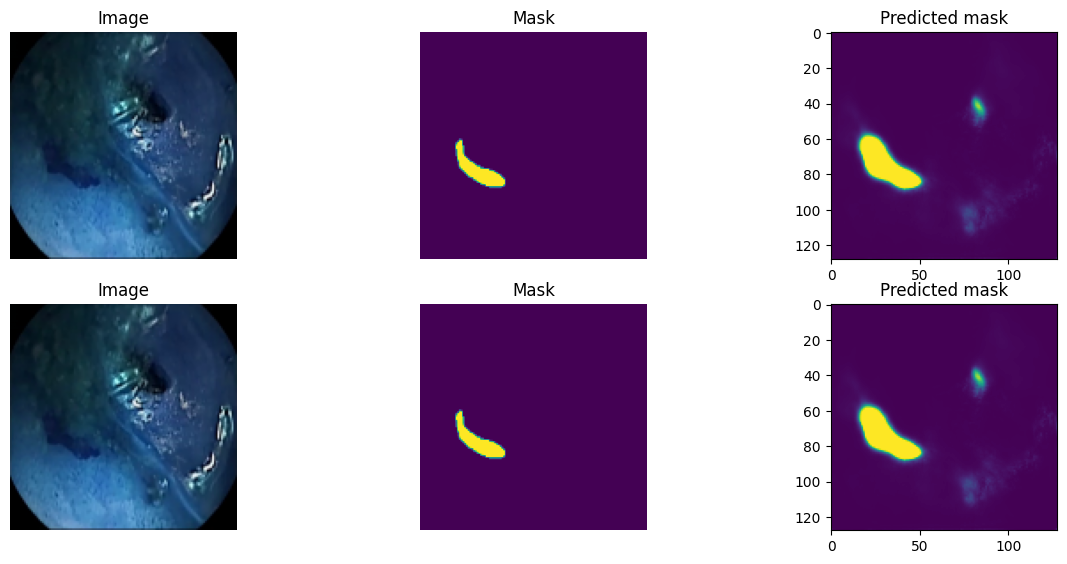


Epoch 1: LearningRateScheduler setting learning rate to 0.0001.
131/131 [==============================] - ETA: 0s - loss: 0.7176 - iou_coef: 0.3132
Epoch 1: val_loss improved from 0.81190 to 0.80940, saving model to /models/unet_best_model.hdf5
1/1 [==============================] - 0s 24ms/step


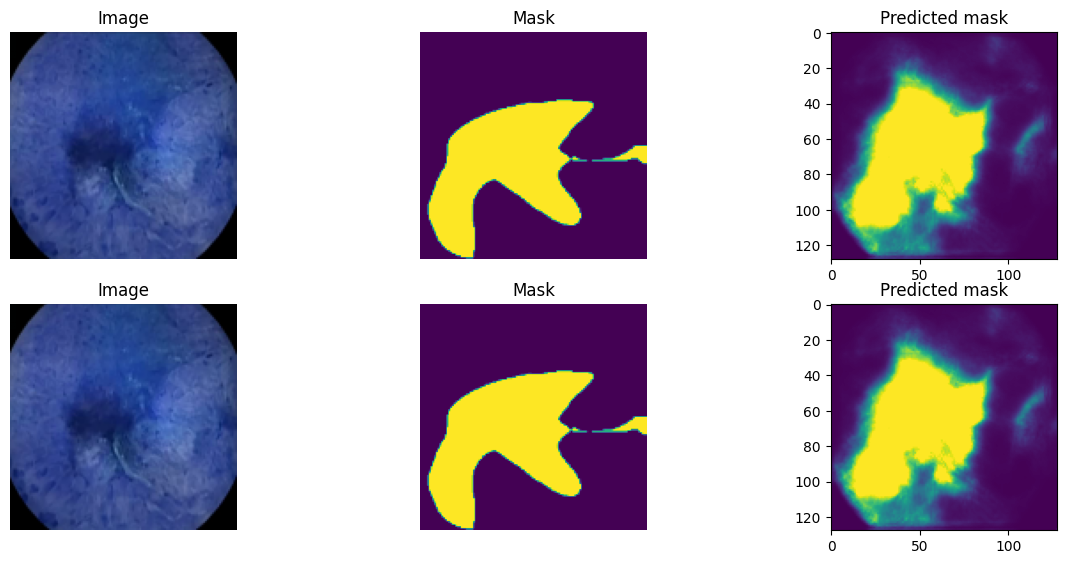


Epoch 1: LearningRateScheduler setting learning rate to 0.0001.
131/131 [==============================] - ETA: 0s - loss: 0.7058 - iou_coef: 0.3213
Epoch 1: val_loss improved from 0.80940 to 0.79220, saving model to /models/unet_best_model.hdf5
1/1 [==============================] - 0s 22ms/step


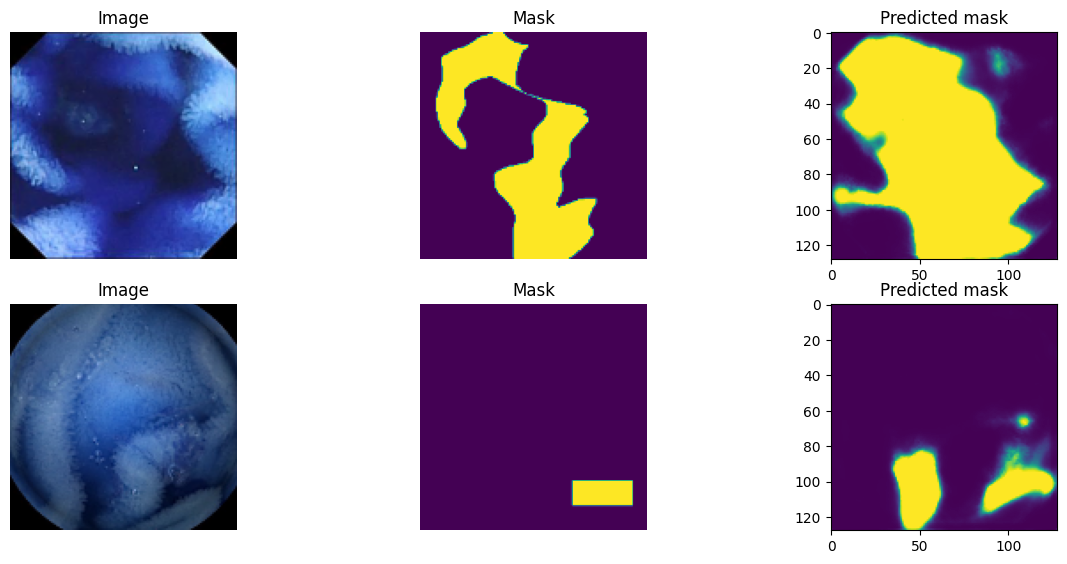


Epoch 1: LearningRateScheduler setting learning rate to 0.0001.
131/131 [==============================] - ETA: 0s - loss: 0.6835 - iou_coef: 0.3313
Epoch 1: val_loss improved from 0.79220 to 0.78852, saving model to /models/unet_best_model.hdf5
1/1 [==============================] - 0s 20ms/step


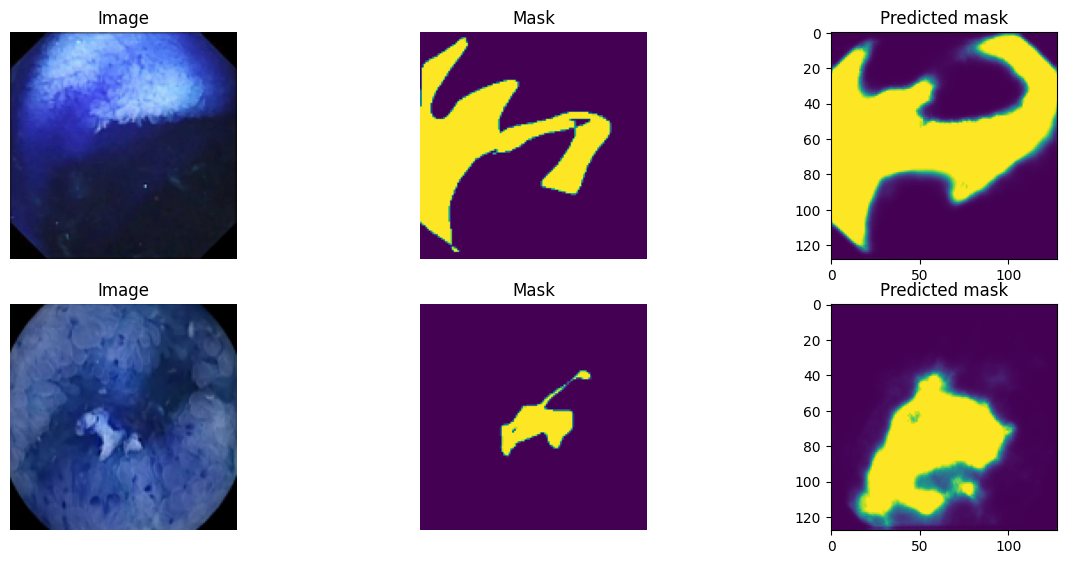


Epoch 1: LearningRateScheduler setting learning rate to 0.0001.
131/131 [==============================] - ETA: 0s - loss: 0.6597 - iou_coef: 0.3481
Epoch 1: val_loss improved from 0.78852 to 0.76329, saving model to /models/unet_best_model.hdf5
1/1 [==============================] - 0s 30ms/step


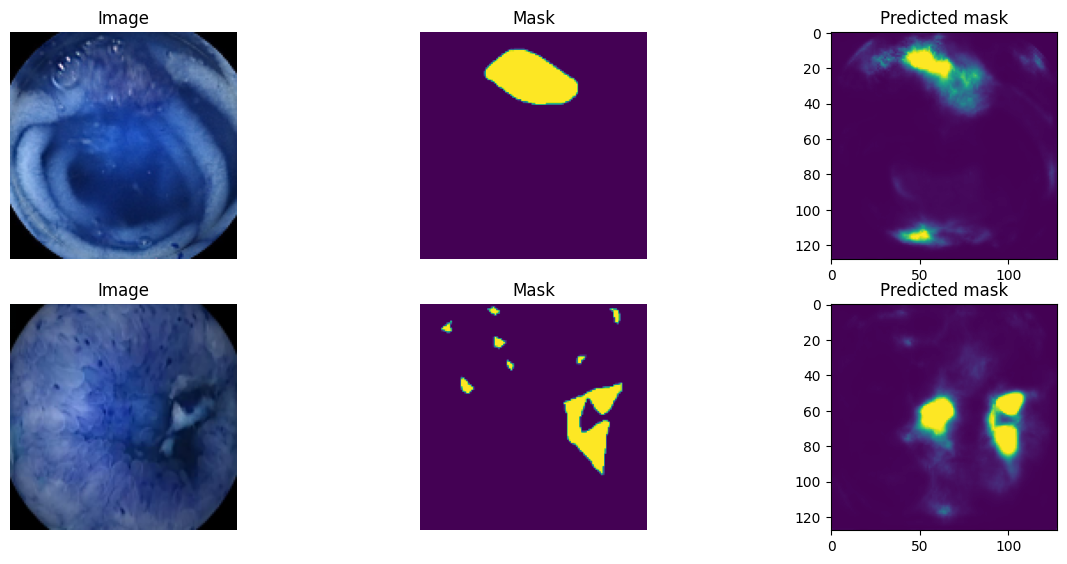


Epoch 1: LearningRateScheduler setting learning rate to 0.0001.
131/131 [==============================] - ETA: 0s - loss: 0.6508 - iou_coef: 0.3545
Epoch 1: val_loss did not improve from 0.76329
1/1 [==============================] - 0s 21ms/step


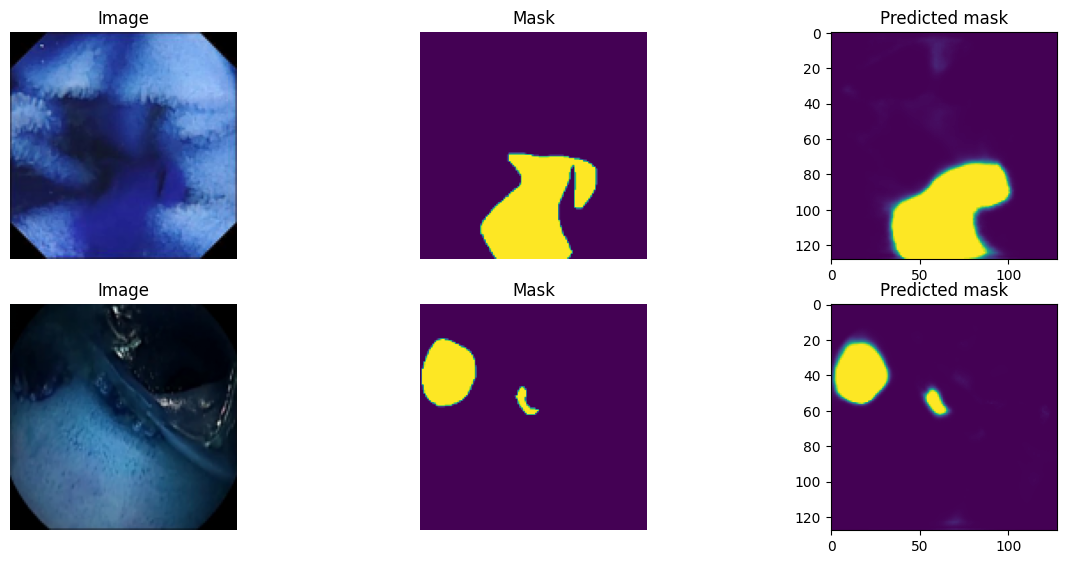


Epoch 1: LearningRateScheduler setting learning rate to 0.0001.
131/131 [==============================] - ETA: 0s - loss: 0.6345 - iou_coef: 0.3642
Epoch 1: val_loss did not improve from 0.76329
1/1 [==============================] - 0s 19ms/step


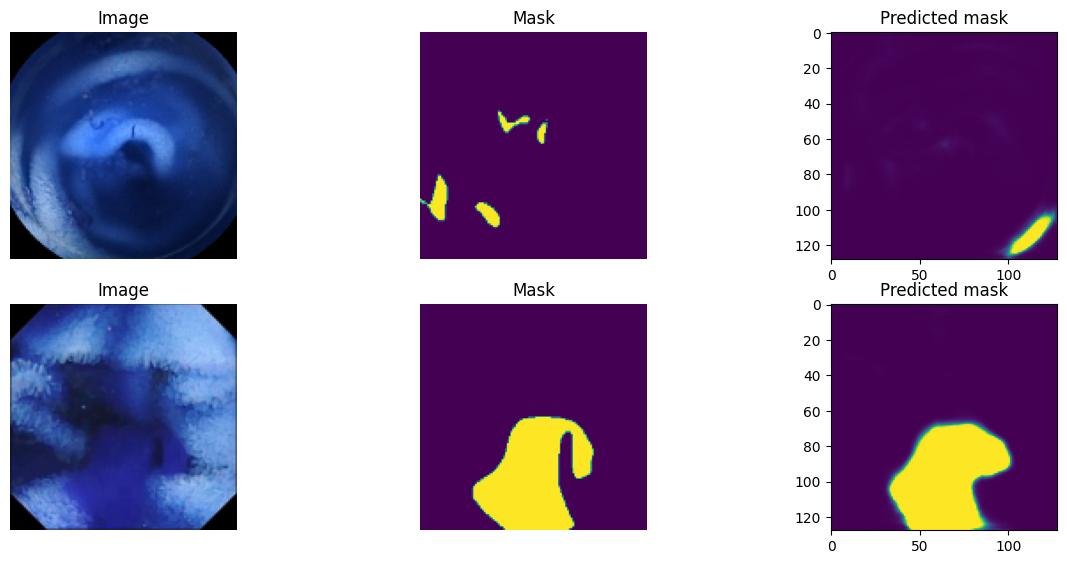


Epoch 1: LearningRateScheduler setting learning rate to 0.0001.
131/131 [==============================] - ETA: 0s - loss: 0.6249 - iou_coef: 0.3719
Epoch 1: val_loss did not improve from 0.76329
1/1 [==============================] - 0s 19ms/step


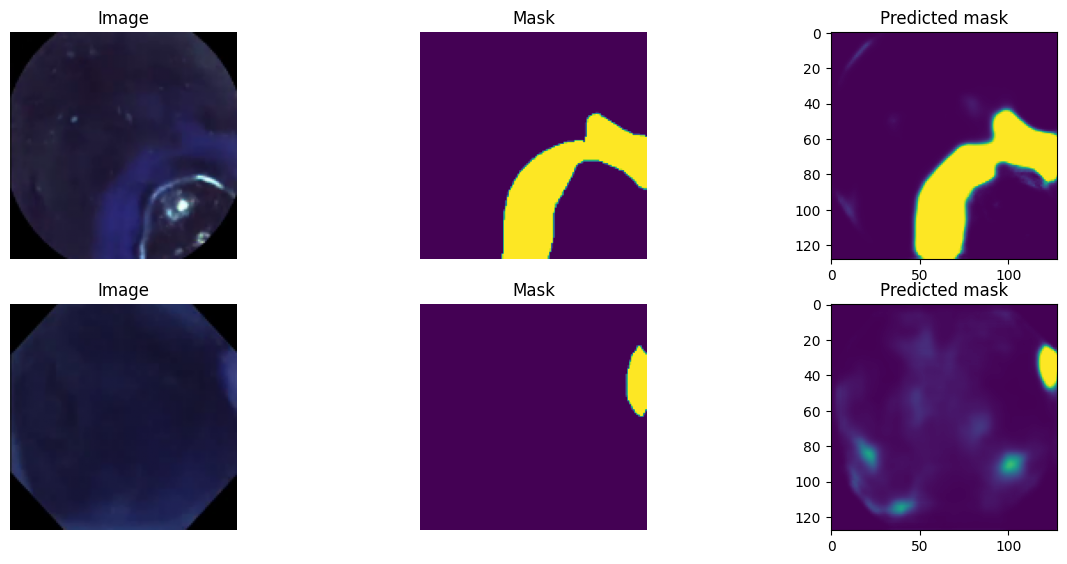


Epoch 1: LearningRateScheduler setting learning rate to 0.0001.
131/131 [==============================] - ETA: 0s - loss: 0.6070 - iou_coef: 0.3828
Epoch 1: val_loss did not improve from 0.76329
1/1 [==============================] - 0s 19ms/step


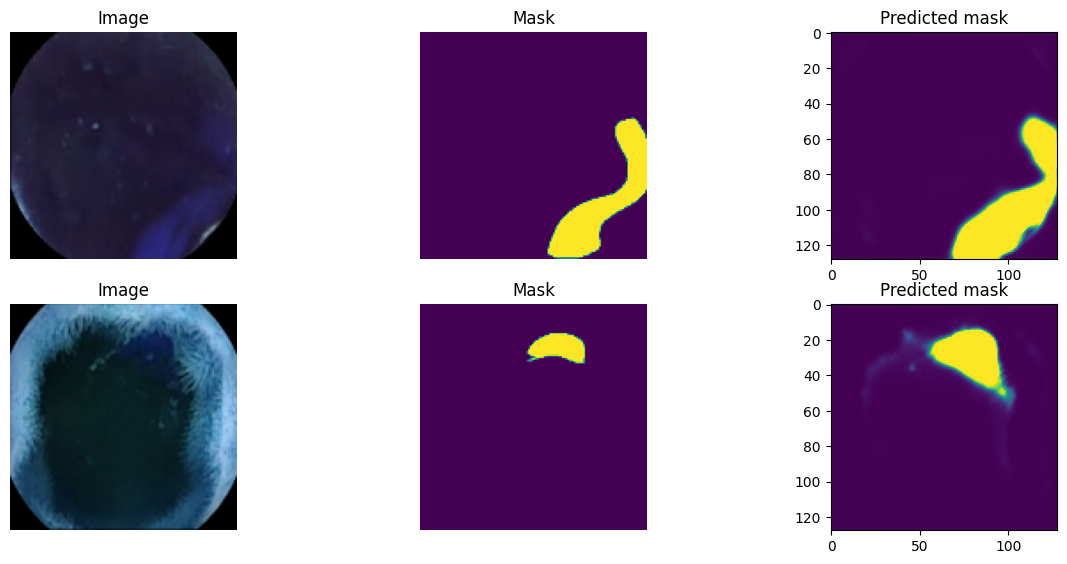


Epoch 1: LearningRateScheduler setting learning rate to 0.0001.
131/131 [==============================] - ETA: 0s - loss: 0.6075 - iou_coef: 0.3839
Epoch 1: val_loss did not improve from 0.76329
1/1 [==============================] - 0s 19ms/step


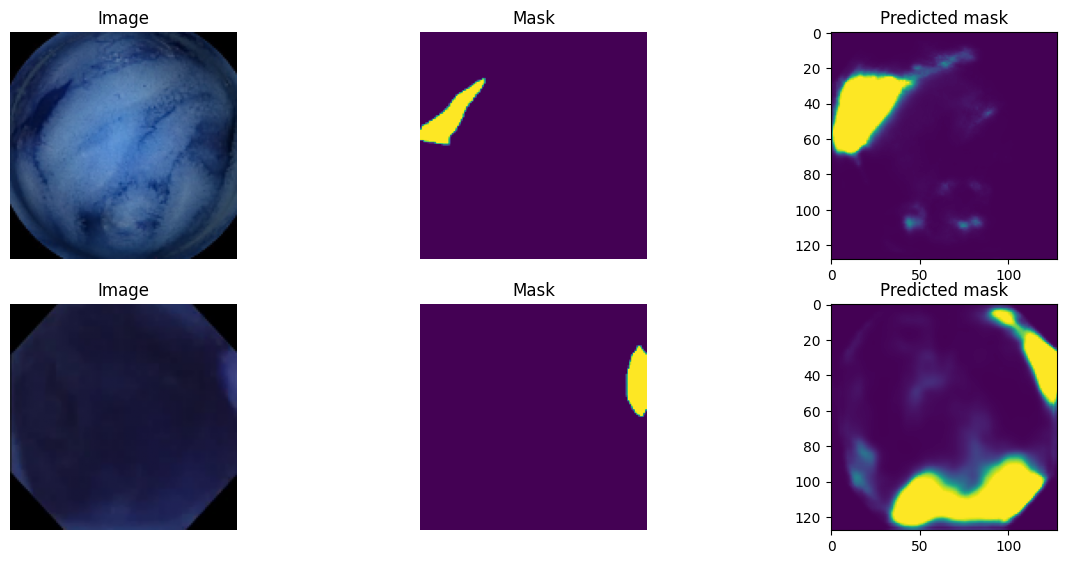


Epoch 1: LearningRateScheduler setting learning rate to 0.0001.
131/131 [==============================] - ETA: 0s - loss: 0.5910 - iou_coef: 0.3942
Epoch 1: val_loss improved from 0.76329 to 0.76082, saving model to /models/unet_best_model.hdf5
1/1 [==============================] - 0s 22ms/step


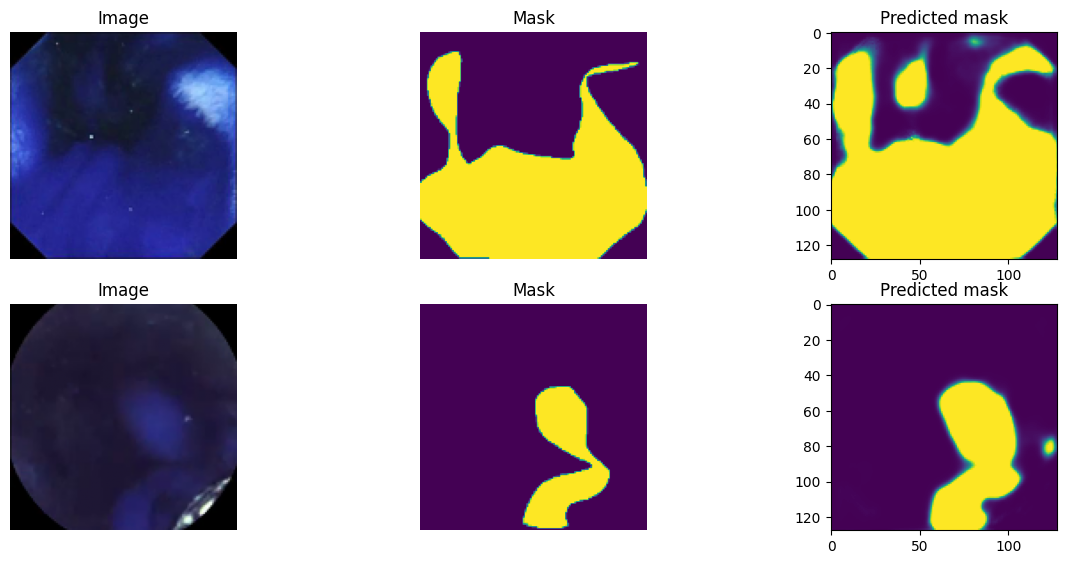


Epoch 1: LearningRateScheduler setting learning rate to 0.0001.
131/131 [==============================] - ETA: 0s - loss: 0.5729 - iou_coef: 0.4072
Epoch 1: val_loss did not improve from 0.76082
1/1 [==============================] - 0s 20ms/step


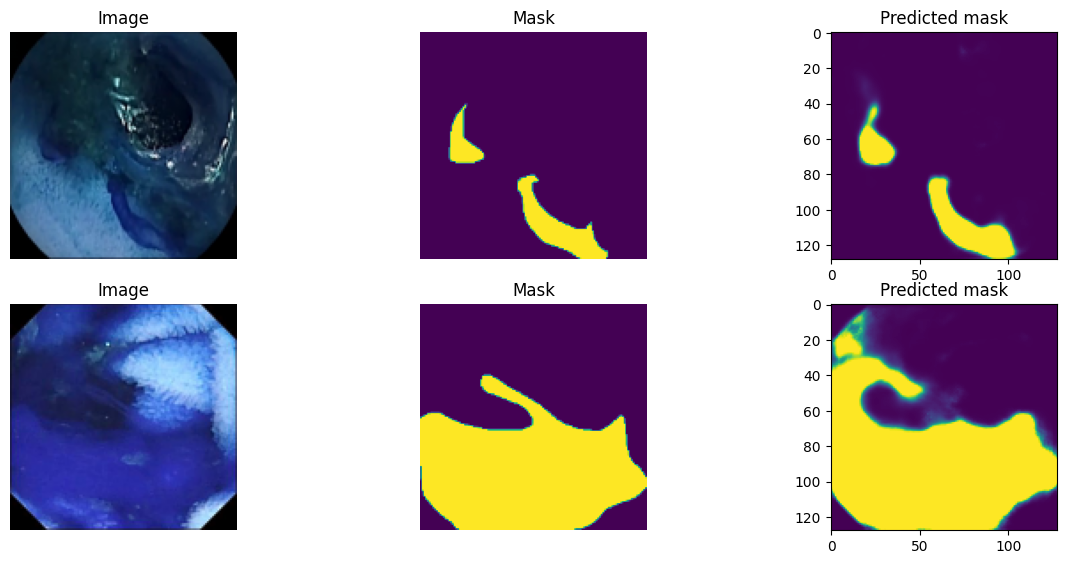


Epoch 1: LearningRateScheduler setting learning rate to 0.0001.
131/131 [==============================] - ETA: 0s - loss: 0.5686 - iou_coef: 0.4111
Epoch 1: val_loss did not improve from 0.76082
1/1 [==============================] - 0s 19ms/step


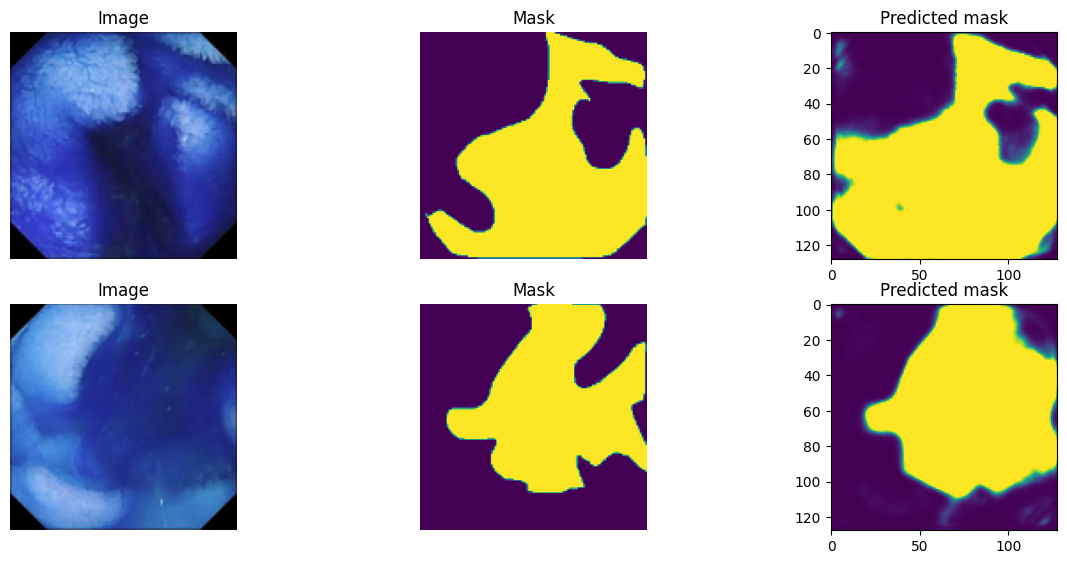


Epoch 1: LearningRateScheduler setting learning rate to 0.0001.
131/131 [==============================] - ETA: 0s - loss: 0.5552 - iou_coef: 0.4212
Epoch 1: val_loss did not improve from 0.76082
1/1 [==============================] - 0s 20ms/step


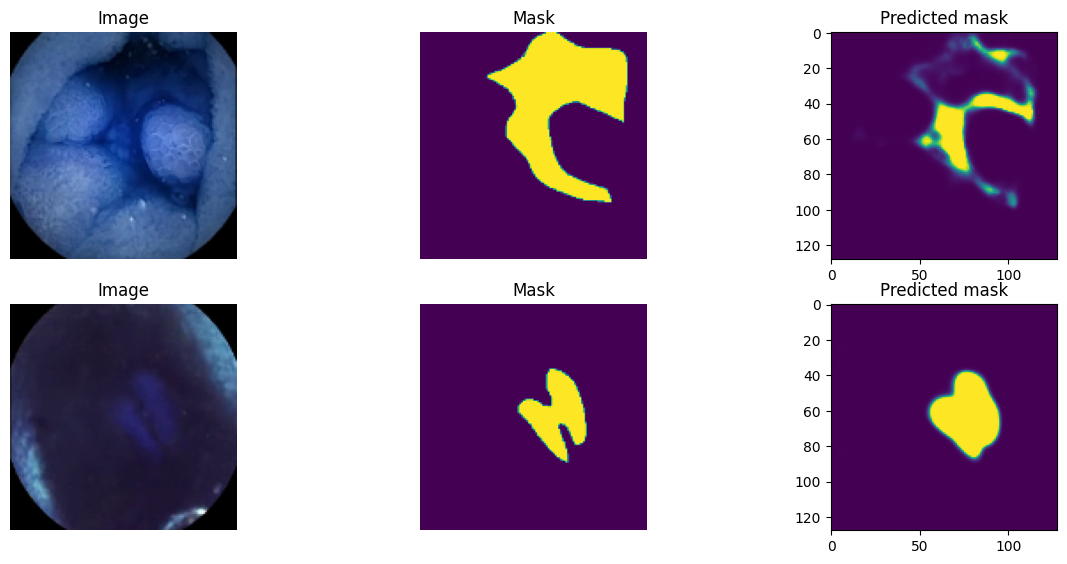


Epoch 1: LearningRateScheduler setting learning rate to 0.0001.
131/131 [==============================] - ETA: 0s - loss: 0.5449 - iou_coef: 0.4298
Epoch 1: val_loss did not improve from 0.76082
1/1 [==============================] - 0s 19ms/step


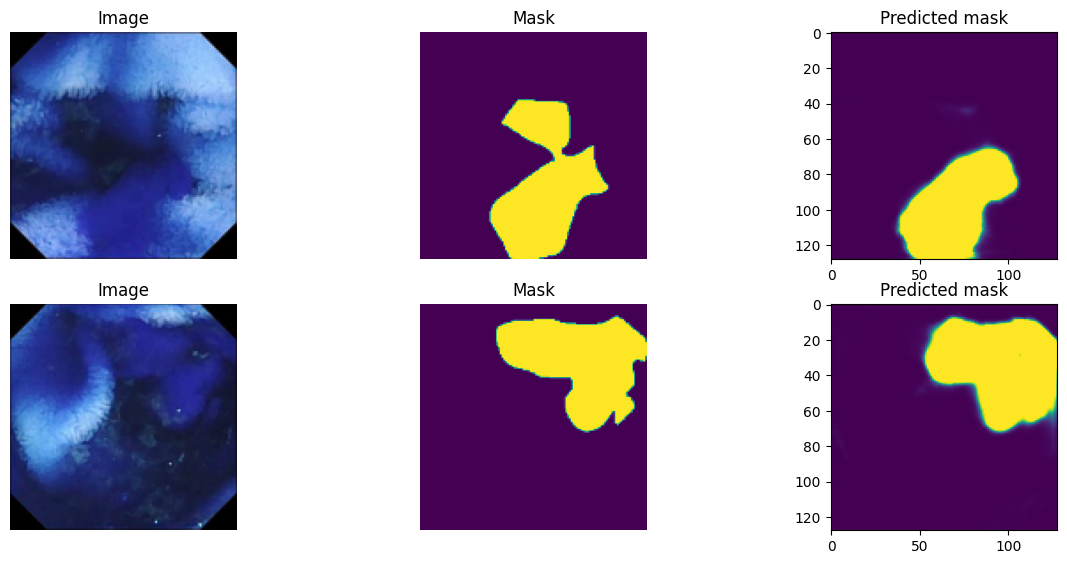


Epoch 1: LearningRateScheduler setting learning rate to 0.0001.
131/131 [==============================] - ETA: 0s - loss: 0.5472 - iou_coef: 0.4274
Epoch 1: val_loss did not improve from 0.76082
1/1 [==============================] - 0s 19ms/step


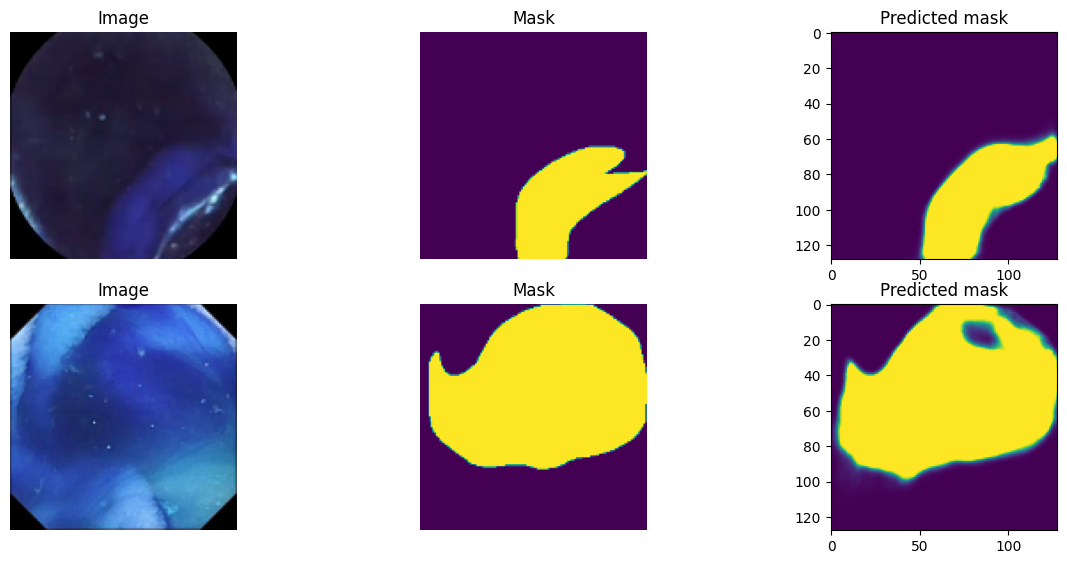


Epoch 1: LearningRateScheduler setting learning rate to 0.0001.
131/131 [==============================] - ETA: 0s - loss: 0.5275 - iou_coef: 0.4398
Epoch 1: val_loss did not improve from 0.76082
1/1 [==============================] - 0s 19ms/step


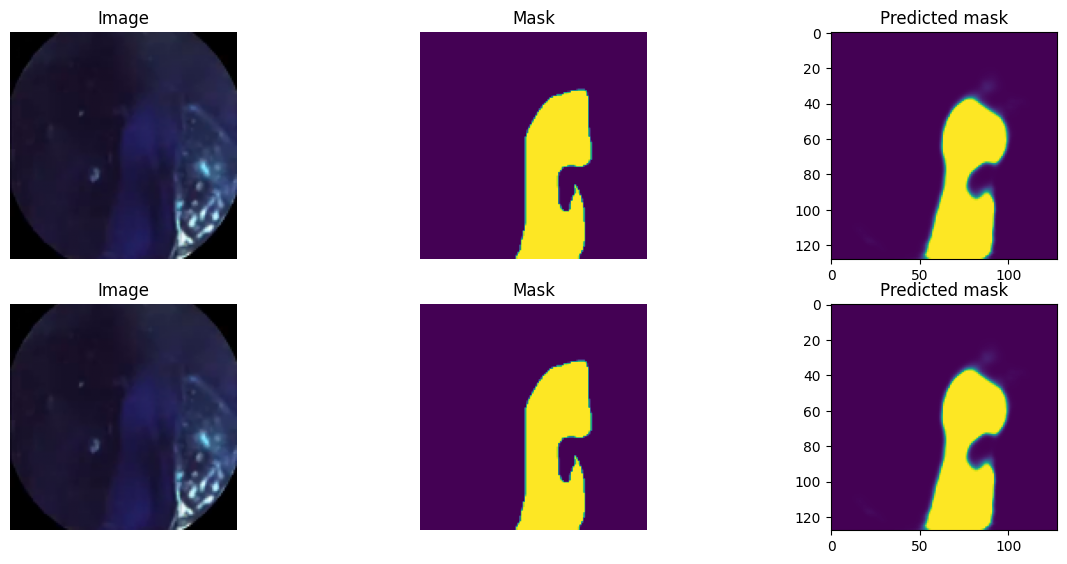


Epoch 1: LearningRateScheduler setting learning rate to 0.0001.
131/131 [==============================] - ETA: 0s - loss: 0.5172 - iou_coef: 0.4502
Epoch 1: val_loss did not improve from 0.76082
1/1 [==============================] - 0s 20ms/step


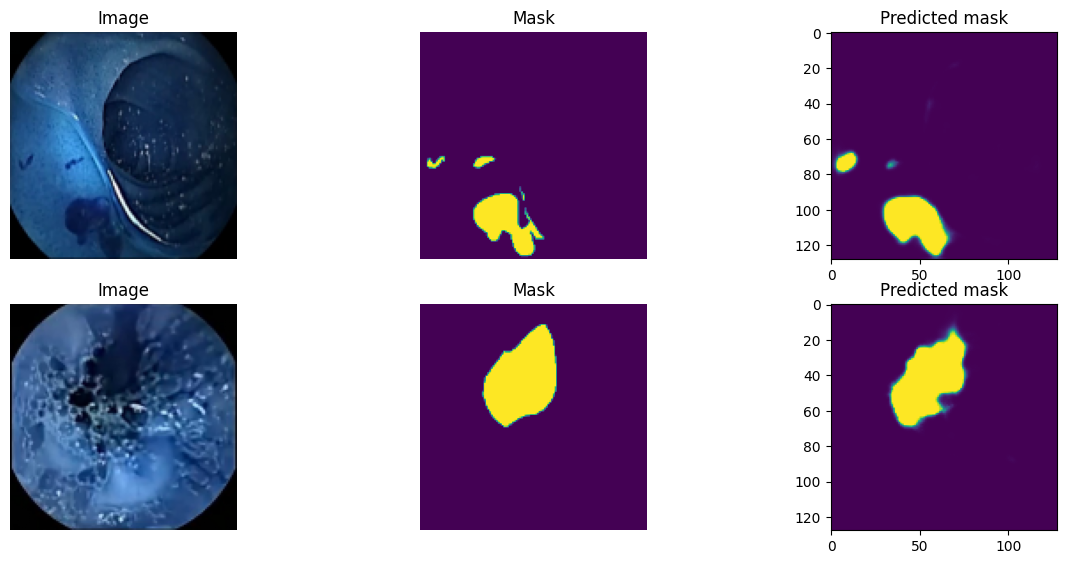


Epoch 1: LearningRateScheduler setting learning rate to 0.0001.
131/131 [==============================] - ETA: 0s - loss: 0.5136 - iou_coef: 0.4526
Epoch 1: val_loss did not improve from 0.76082
1/1 [==============================] - 0s 19ms/step


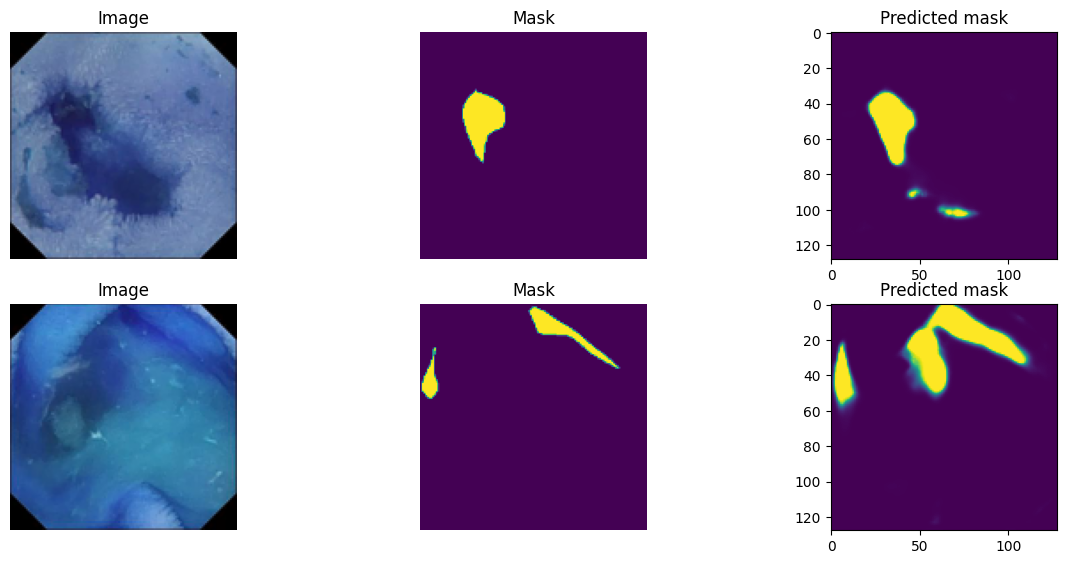


Epoch 1: LearningRateScheduler setting learning rate to 0.0001.
131/131 [==============================] - ETA: 0s - loss: 0.5071 - iou_coef: 0.4578
Epoch 1: val_loss did not improve from 0.76082
1/1 [==============================] - 0s 20ms/step


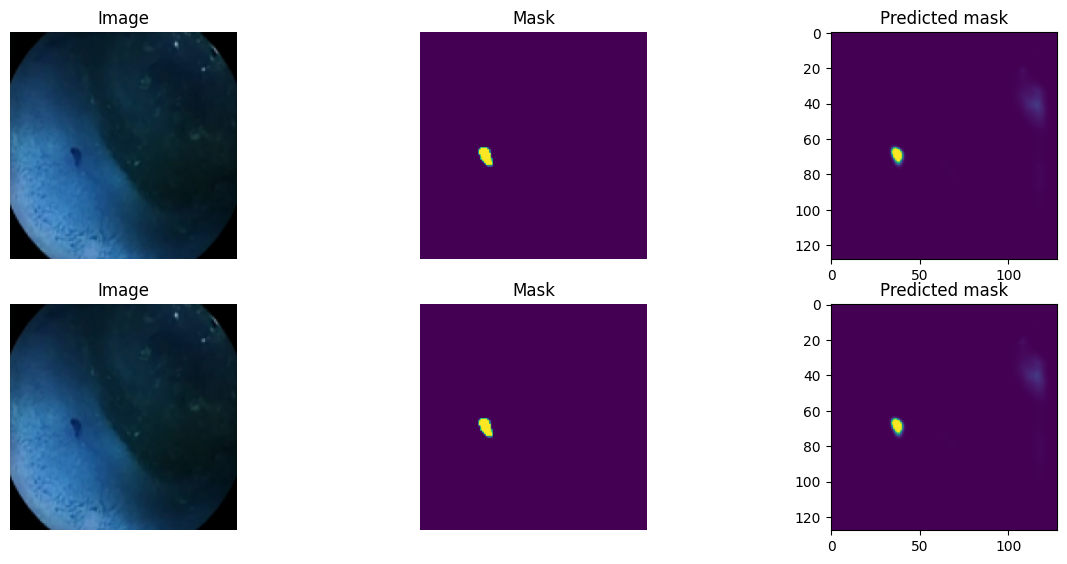


Epoch 1: LearningRateScheduler setting learning rate to 0.0001.
131/131 [==============================] - ETA: 0s - loss: 0.4989 - iou_coef: 0.4654
Epoch 1: val_loss improved from 0.76082 to 0.75138, saving model to /models/unet_best_model.hdf5
1/1 [==============================] - 0s 19ms/step


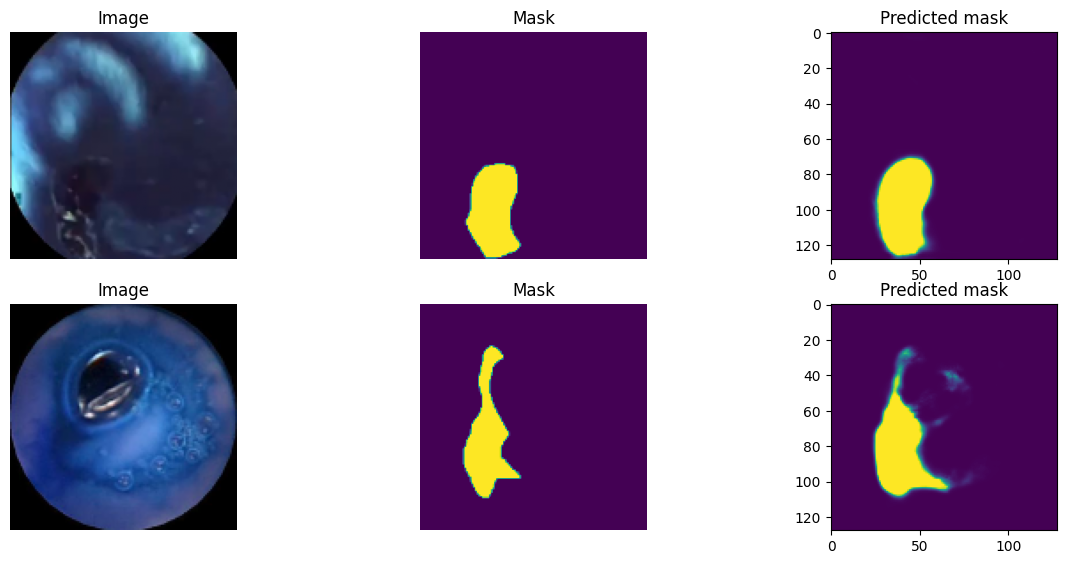


Epoch 1: LearningRateScheduler setting learning rate to 0.0001.
131/131 [==============================] - ETA: 0s - loss: 0.4906 - iou_coef: 0.4707
Epoch 1: val_loss did not improve from 0.75138
1/1 [==============================] - 0s 33ms/step


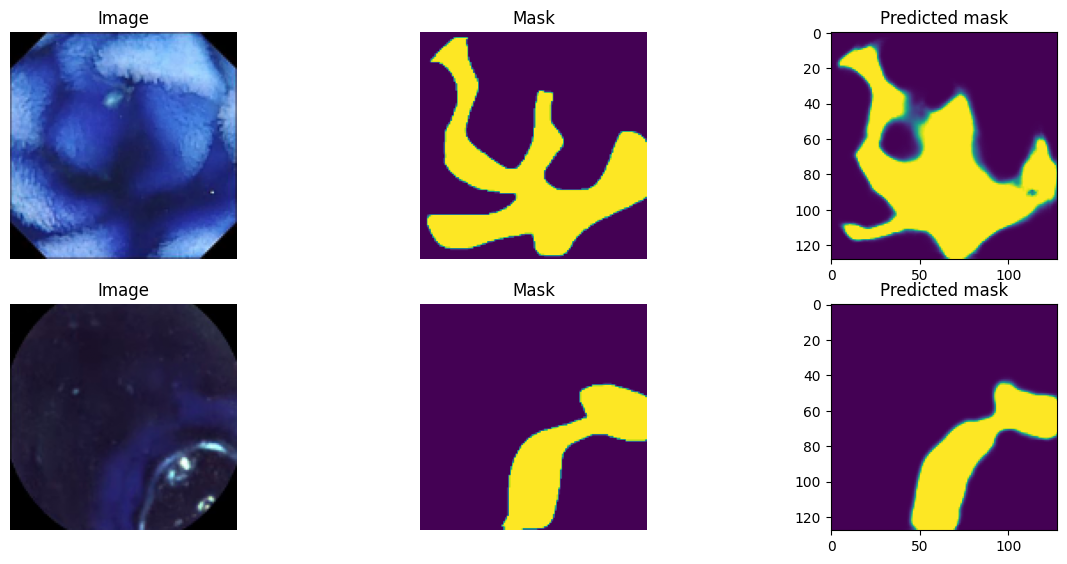


Epoch 1: LearningRateScheduler setting learning rate to 0.0001.
131/131 [==============================] - ETA: 0s - loss: 0.4862 - iou_coef: 0.4730
Epoch 1: val_loss did not improve from 0.75138
1/1 [==============================] - 0s 19ms/step


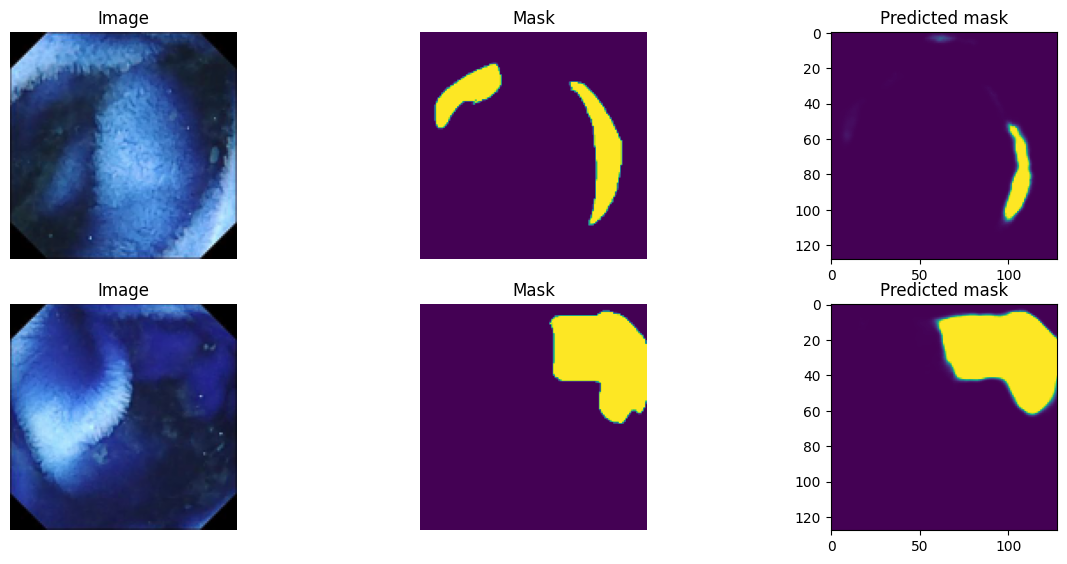


Epoch 1: LearningRateScheduler setting learning rate to 0.0001.
131/131 [==============================] - ETA: 0s - loss: 0.4855 - iou_coef: 0.4743
Epoch 1: val_loss did not improve from 0.75138
1/1 [==============================] - 0s 19ms/step


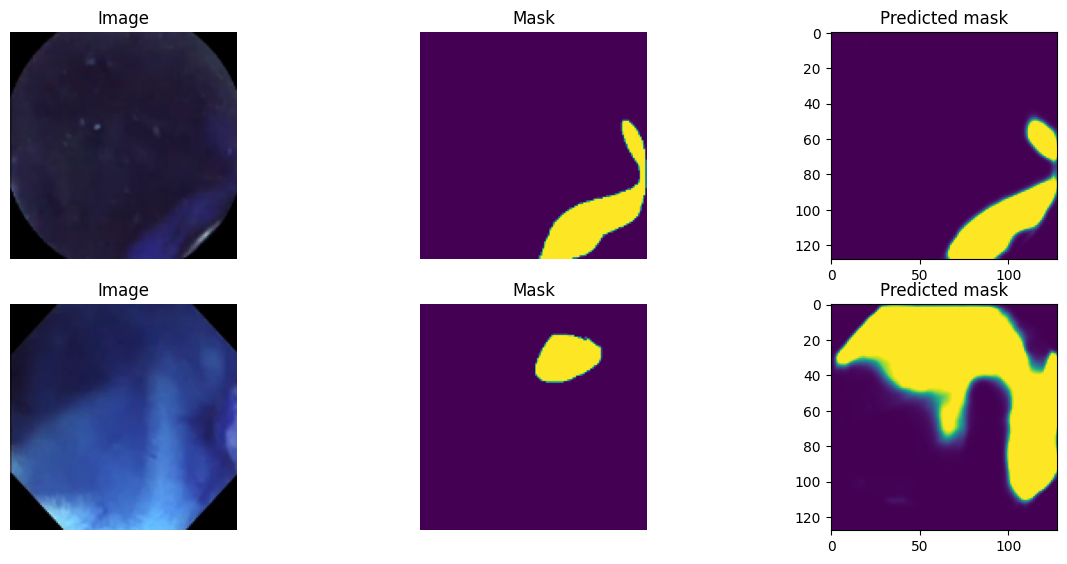

In [227]:
epochs = 30
for _ in range(epochs):
    history = model.fit(
        train_gen, 
        validation_data = val_gen, 
        epochs=1,
        callbacks=callbacks_list,
        steps_per_epoch=len(train_gen),
        validation_steps = len(val_gen)
    )
    plot_sample_predictions(model, train_gen, count_images=2)

## Prediction

In [228]:
image_paths_list = '/kaggle/working/TEST/T1'
z1 = []
for path in os.listdir(image_paths_list):
    z1.append(path) 
df = pd.DataFrame.from_dict({"files": z1})
df.to_csv('sample-submission.csv', index=False)

In [229]:
sample_submission = pd.read_csv('sample-submission.csv')
sample_submission.head()

files
0  A0515.png
1  A0265.png
2  A0371.png
3  A0314.png
4  A0558.png

In [230]:
!ls ../input

wcebleedgen


In [231]:
#выставляем пороговое значение вероятности для классификации, с этим можно поиграться
def get_mask(model, img_orig, threshold = None):
    mask = model.predict(img_orig)
    if threshold is not None:
        mask = np.where(mask > threshold, 1, 0)
    return mask

In [232]:
image_paths_list = '/kaggle/working/TEST/T1'
predictions = []
from tqdm.notebook import tqdm
# images = cv2.imread(image_paths_list)
# print(images)
fig = plt.figure(figsize=(15, 10))
k=0
for path in tqdm(os.listdir(image_paths_list)):
    p1 = os.path.join(image_paths_list, path)
#     print(p1)
    image = cv2.imread(p1, 1)
#     image_size= (128,128)
#     image = cv2.resize(image , image_size)
#     img = image.reshape(1, image.shape[0], image.shape[1], image.shape[2])
#     pred_mask = model.predict(img)
#     

    image = cv2.resize(image , IMAGE_SIZE)
    image = np.array(image)
    
#     fig.add_subplot(3, 3, k + 1) 
#     plt.imshow(image)
#     plt.title('Image') #даем название холсту
#     plt.axis('off')
    
#     plt.imshow(image)
    image = image.reshape(1, *image.shape)
#     pred_mask = model.predict(image)
   
#     pred_mask = cv2.cvtColor(pred_mask[0, :, :, :], cv2.COLOR_GRAY2RGB)
#     print(pred_mask.shape)
    
#     fig.add_subplot(3, 3, k + 2)
#     plt.imshow(pred_mask)
#     plt.title('Predicted mask') #даем название холсту
#     k += 2
#     size = (1,128,128,3)
#     pred_mask = cv2.resize(pred_mask, size)
#     plt.imshow(pred_mask[0, :, :, :])
#     plt.imshow(pred_mask)
    
#     
    
    image = image / 255
    predictions.append(get_mask(model,image, 0.2))
plt.show()

  0%|          | 0/564 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


<Figure size 1500x1000 with 0 Axes>

  0%|          | 0/564 [00:00<?, ?it/s]

ValueError: num must be an integer with 1 <= num <= 50, not 51

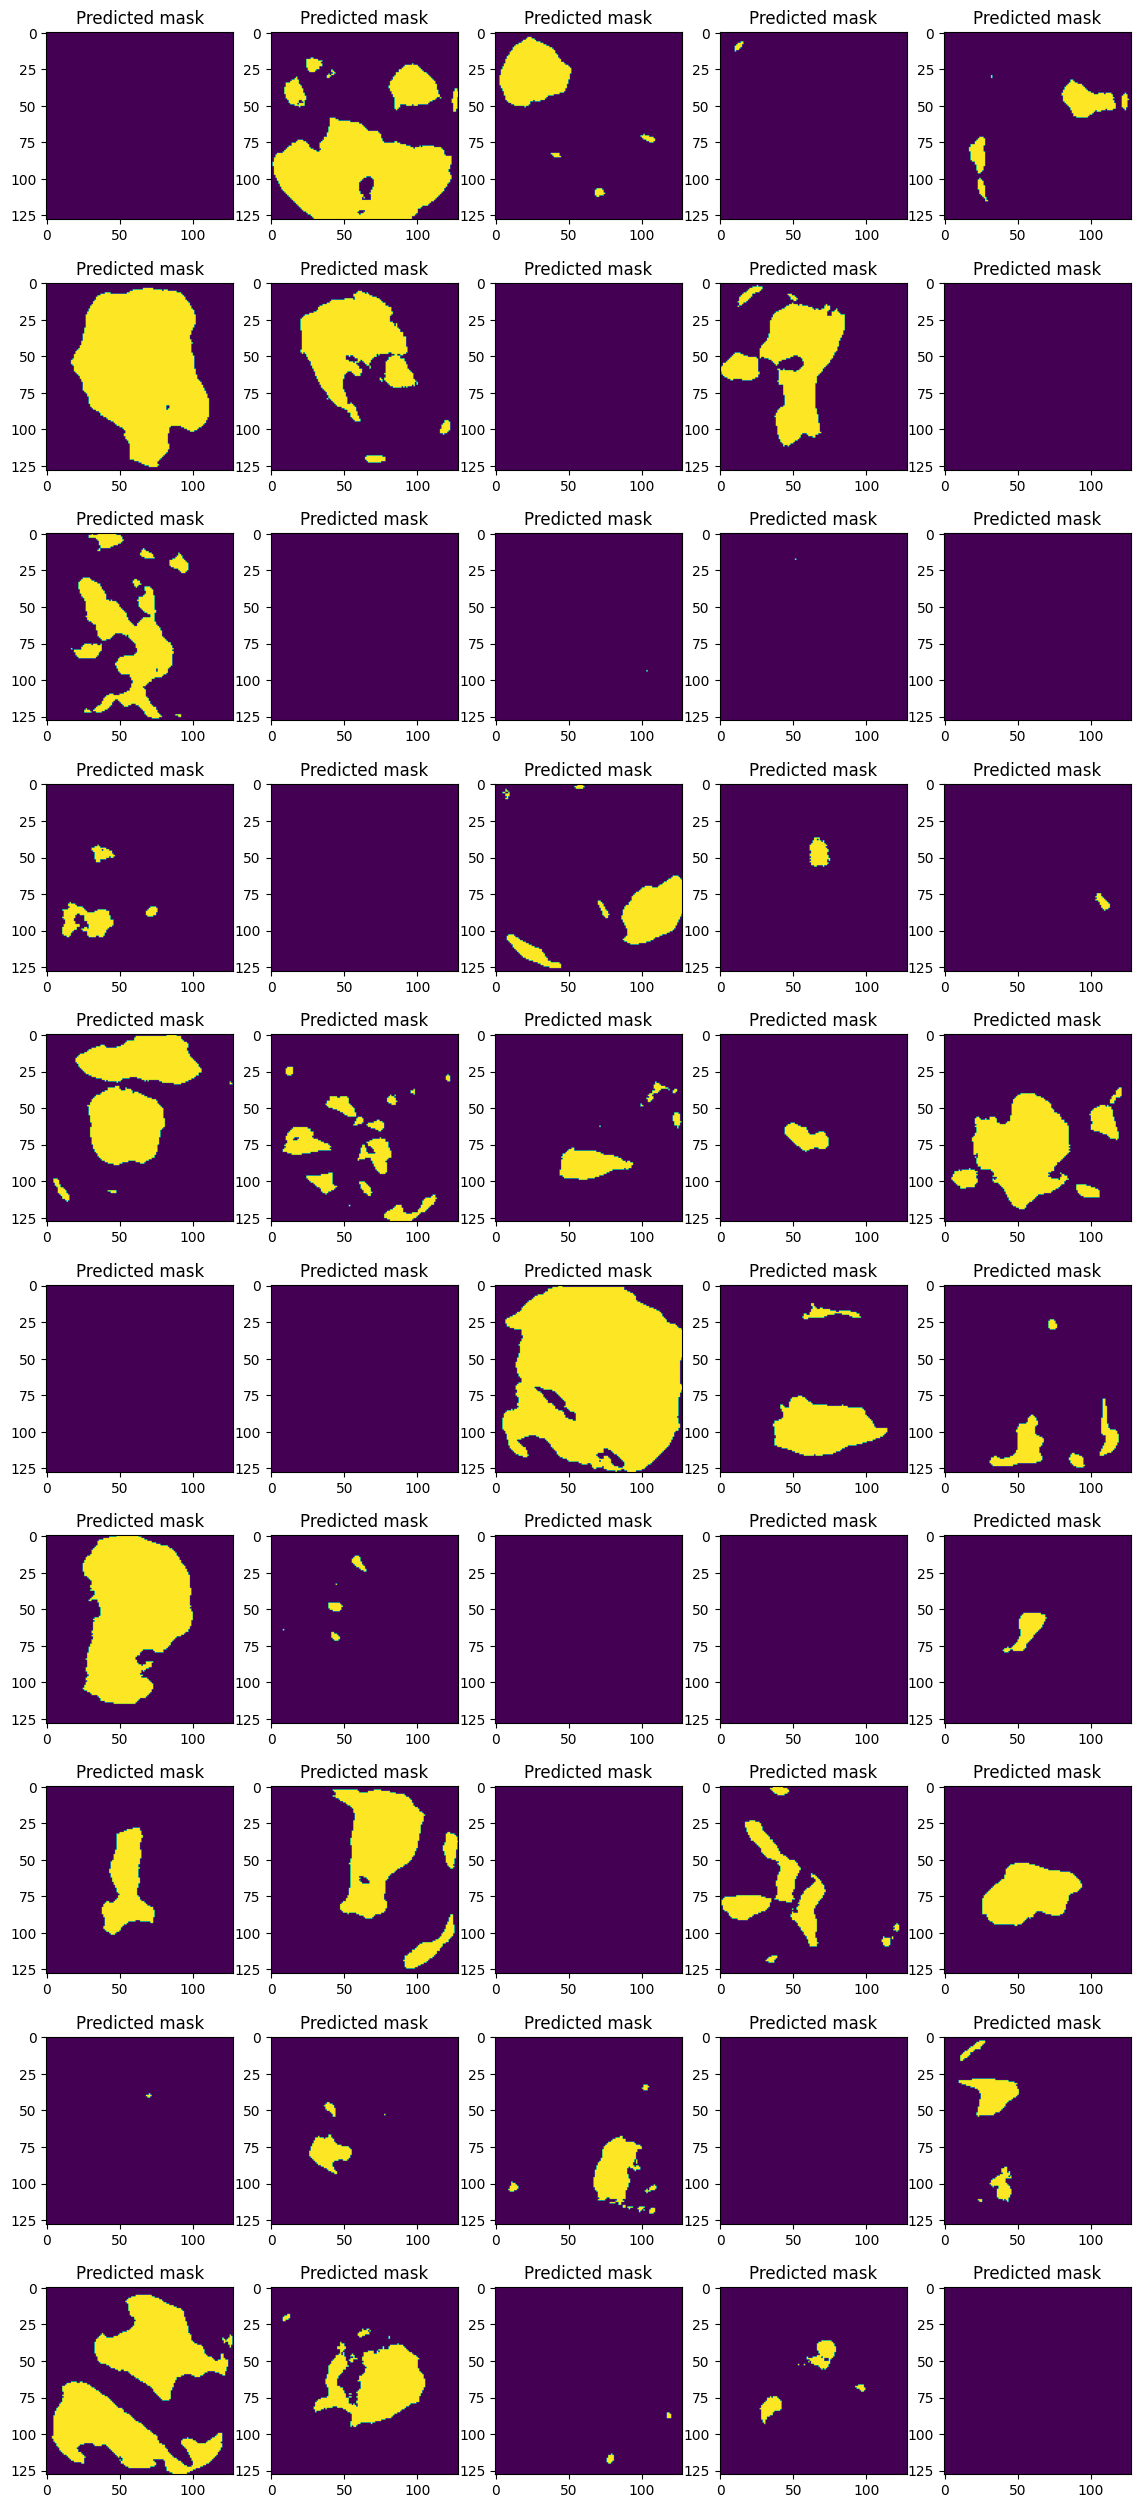

In [233]:
fig = plt.figure(figsize=(14, 32))
k=0
for mask in tqdm(predictions):
    mask = np.array(mask)
#     print(mask.shape)
    mask = mask[0,:,:,:]
    
    fig.add_subplot(10, 5, k+1)
    plt.imshow(mask)
    plt.title('Predicted mask') #даем название холсту
    k += 1
#     plt.imshow(mask)
#     mask = cv2.cvtColor(mask, cv2.COLOR_GRAY2RGB)
#     print(mask.shape)

In [234]:
def mask_to_rle(mask):
    mask_flat = mask.flatten('F')
    flag = 0
    rle_list = list()
    for i in range(mask_flat.shape[0]):
        if flag == 0:
            if mask_flat[i] == 1:
                flag = 1
                starts = i+1
                rle_list.append(starts)
        else:
            if mask_flat[i] == 0:
                flag = 0
                ends = i
                rle_list.append(ends-starts+1)
    if flag == 1:
        ends = mask_flat.shape[0]
        rle_list.append(ends-starts+1)
    #sanity check
    if len(rle_list) % 2 != 0:
        print('NG')
    if len(rle_list) == 0:
        rle = np.nan
    else:
        rle = ' '.join(map(str,rle_list))
    return rle

predictions_encoded = [mask_to_rle(mask) for mask in tqdm(predictions)]
sample_submission['EncodedPixels'] = predictions_encoded
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head()

  0%|          | 0/564 [00:00<?, ?it/s]

files                                      EncodedPixels
0  A0515.png                                                NaN
1  A0265.png  218 3 343 12 469 16 596 19 724 21 852 23 980 2...
2  A0371.png  415 7 539 13 665 17 791 22 916 28 1042 31 1169...
3  A0314.png          1291 4 1418 4 1545 5 1673 4 1800 4 1928 2
4  A0558.png  2256 3 2382 11 2510 12 2638 12 2764 16 2891 21...